<a href="https://colab.research.google.com/github/akfalah/machine-learning/blob/main/2241720184_AhmadKhoirulFalah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# @title Import library yang diperlukan

from google.colab import drive  # Untuk mengakses Google Drive
import zipfile
import random
import dlib  # Untuk deteksi wajah dan landmark
import cv2 as cv  # OpenCV untuk pemrosesan gambar
import numpy as np  # Untuk operasi numerik
import os  # Untuk operasi sistem (file dan direktori)
import matplotlib.pyplot as plt  # Untuk visualisasi
import seaborn as sns  # Untuk visualisasi yang lebih baik
from sklearn.cluster import DBSCAN  # Untuk algoritma clustering DBSCAN
from sklearn.metrics import silhouette_score  # Untuk evaluasi clustering
from sklearn.model_selection import train_test_split  # Untuk membagi dataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score  # Untuk evaluasi model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [46]:
# @title Mount Google Drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# @title Load Data

# Mendefinisikan jalur ke file zip yang akan diekstrak
zip_path = '/content/drive/My Drive/kuliah/dataset.zip'
extract_path = 'images'

# Membuka file zip dan mengekstrak
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

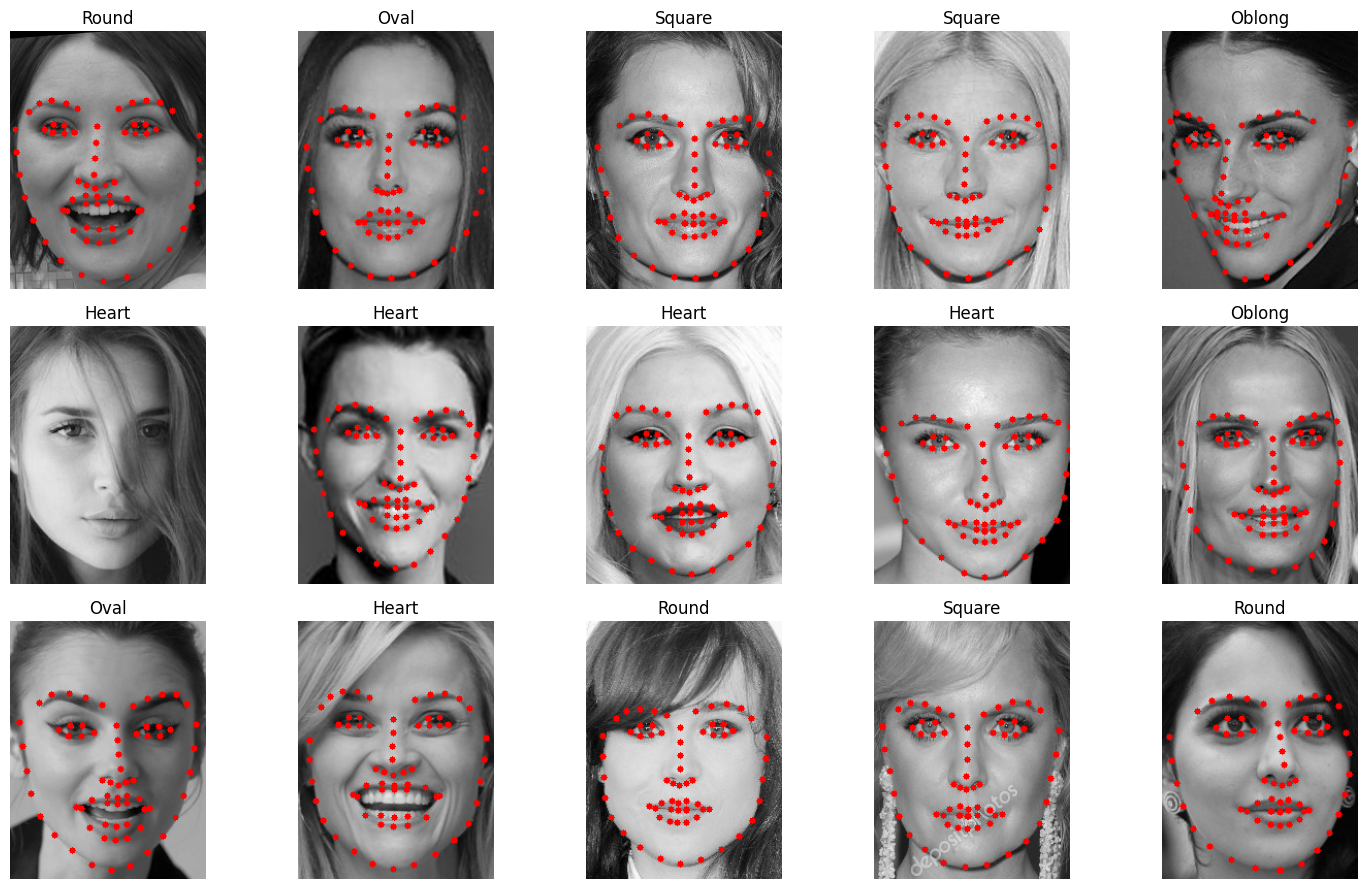

In [51]:
# @title Contoh image yang sudah diextract featuresnya

# Inisialisasi dlib's face detector dan facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/kuliah/shape_predictor_68_face_landmarks.dat')

image_dir = 'images/dataset'


# Mendapatkan daftar semua gambar dalam direktori
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Pilih 15 gambar acak untuk visualisasi
selected_images = random.sample(image_files, 15)

# Siapkan figure untuk plot
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

# Mendeteksi wajah dan menggambar landmark
for ax, image_file in zip(axes, selected_images):
    # Memuat gambar
    image_path = os.path.join(image_dir, image_file)
    image = cv.imread(image_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Mendeteksi wajah
    faces = detector(gray)

    # Menggambar landmark
    for face in faces:
        landmarks = predictor(gray, face)
        landmarks_np = np.array([[p.x, p.y] for p in landmarks.parts()])

        # Menampilkan landmark di gambar
        for (x, y) in landmarks_np:
            cv.circle(image, (x, y), 3, (0, 0, 255), -1)

    # Menambahkan label pada gambar
    label = image_file.split('(')[0]  # Mengambil nama file sebagai label

    # Konversi BGR ke RGB untuk ditampilkan dengan matplotlib
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Menampilkan gambar di subplot
    ax.imshow(image_rgb, cmap='gray')
    ax.set_title(label)
    ax.axis('off')  # Menyembunyikan sumbu

# Menyesuaikan layout
plt.tight_layout()
plt.show()

In [50]:
# Daftar untuk menyimpan fitur dan label
features_list = []
labels = []

# Fungsi untuk mengekstrak fitur dari gambar
def extract_features(image_path):
    # Memuat gambar dari path yang diberikan
    img = cv.imread(image_path)

    # Jika gambar tidak dapat dimuat, kembalikan None
    if img is None:
        return None

    # Mengubah gambar ke grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Mendeteksi wajah dalam gambar grayscale
    faces = detector(gray)

    # Jika tidak ada wajah terdeteksi, kembalikan None
    if len(faces) == 0:
        return None  # Jika tidak ada wajah terdeteksi

    # Memprediksi landmark wajah menggunakan wajah yang terdeteksi
    shape = predictor(img, faces[0])
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])

    # Flatten landmarks untuk memastikan formatnya benar
    return landmarks.flatten()

# Mengiterasi melalui semua file dalam direktori dataset
for filename in os.listdir(extract_path + '/dataset'):
    # Memeriksa apakah file adalah gambar dengan ekstensi .jpg atau .png
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Mengambil label dari nama file
        label = filename.split('(')[0]

        # Mengekstrak fitur dari gambar
        features = extract_features(os.path.join(extract_path + '/dataset', filename))

        # Jika fitur berhasil diekstrak, tambahkan ke daftar
        if features is not None:
            features_list.append(features)
            labels.append(label)

# Mengonversi daftar fitur dan label ke array NumPy
features_list = np.array(features_list)
labels = np.array(labels)

# Mencetak jumlah label yang sudah diekstraksi
print("Jumlah label yang sudah diekstraksi:", len(labels))

Jumlah label yang sudah diekstraksi: 3958


In [ ]:
# Encode labels menjadi numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Standarisasi fitur
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_list)

# Membagi dataset menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y_encoded, test_size=0.2, random_state=42)

# Mencetak jumlah data untuk setiap set
print(f'Jumlah data pelatihan (X_train): {X_train.shape[0]}')
print(f'Jumlah data pengujian (X_test): {X_test.shape[0]}')
print(f'Jumlah label pelatihan (y_train): {len(y_train)}')
print(f'Jumlah label pengujian (y_test): {len(y_test)}')

In [ ]:
# Konversi label menjadi one-hot encoding untuk ANN
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Membangun model ANN
model_ann = Sequential()
model_ann.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model_ann.add(Dense(64, activation='relu'))
model_ann.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Kompilasi model ANN
model_ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Melatih model ANN
model_ann.fit(X_train, y_train_one_hot, epochs=50, batch_size=10, verbose=1)

# Prediksi untuk data uji
y_pred_test_ann = model_ann.predict(X_test)
y_pred_test_ann = np.argmax(y_pred_test_ann, axis=1)

# Evaluasi akurasi ANN
accuracy_test_ann = accuracy_score(y_test, y_pred_test_ann)
print(f'Akurasi ANN (Test): {accuracy_test_ann}')

# Confusion Matrix untuk ANN
confusion_test_ann = confusion_matrix(y_test, y_pred_test_ann)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_test_ann, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix ANN')
plt.show()

In [ ]:
# Confusion Matrix untuk ANN
confusion_test_ann = confusion_matrix(y_test, y_pred_test_ann)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_test_ann, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix ANN')
plt.show()

In [ ]:
# Inisialisasi DBSCAN
dbscan = DBSCAN(eps=3, min_samples=2)

# Menerapkan DBSCAN pada fitur
clusters_dbscan = dbscan.fit_predict(features_scaled)

# Evaluasi Silhouette Score untuk DBSCAN
silhouette_avg_dbscan = silhouette_score(features_scaled, clusters_dbscan)
print(f'Silhouette Score DBSCAN: {silhouette_avg_dbscan}')

# Visualisasi hasil clustering dengan DBSCAN
plt.figure(figsize=(10, 6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=clusters_dbscan, cmap='viridis', marker='o', s=50, alpha=0.6, edgecolors='k')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.show()

In [ ]:
print("Classification Report ANN (Test):")
print(classification_report(y_test, y_pred_test_ann))

# Evaluasi Silhouette Score
print(f'Silhouette Score DBSCAN: {silhouette_avg_dbscan}')